In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from random import shuffle
%matplotlib inline

## Camera Calibration

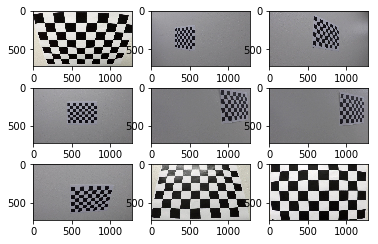

In [2]:
images = glob.glob('./camera_cal/*.jpg')
shuffle(images)

#show some images that will be used in calibration
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    img = mpimg.imread(images[i])
    plt.imshow(img)

plt.show()

In [3]:
#number of x and y corners
nx = 9
ny = 6

#map the coordinates of corners in this 2D image
imgpoints = [] #2D points in image plane

# to the 3D coordinates of the real world, undistorted chessboard corners
objpoints = [] #3D points in real world space

#prepare object points, like (0, 0, 0) (2, 0, 0) ... (8, 5, 0)
objp = np.zeros((nx * ny, 3), np.float32) 
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coordinates

for path in images:
    
    img = mpimg.imread(path)
    
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    #draw the corners
    if ret == True:
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        imgpoints.append(corners)
        objpoints.append(objp)        

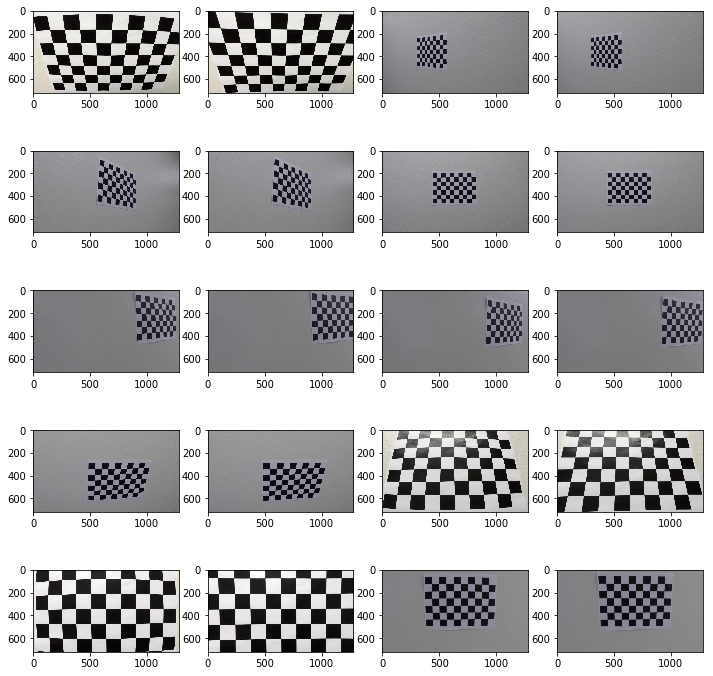

In [4]:
# test undistort

'''
mtx = camera matrix, that we need to transform 3D object points to 2D image points
dits = distortion coefficients

- Position camera in the world

rvecs = rotation vectors
tvecs = translation vectors
'''

# gets the first image to gets the shape
img_sample = mpimg.imread(images[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_sample.shape[0:2], None, None)

fig, ax = plt.subplots(5, 4)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(12, 12)

col = 0
row = 0
for i in range(0, 10):
    img = mpimg.imread(images[i])
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    ax[row][col].imshow(img)
    col += 1
    ax[row][col].imshow(undist)
    col += 1
    if (col == 4):
        col = 0
        row += 1

plt.show()

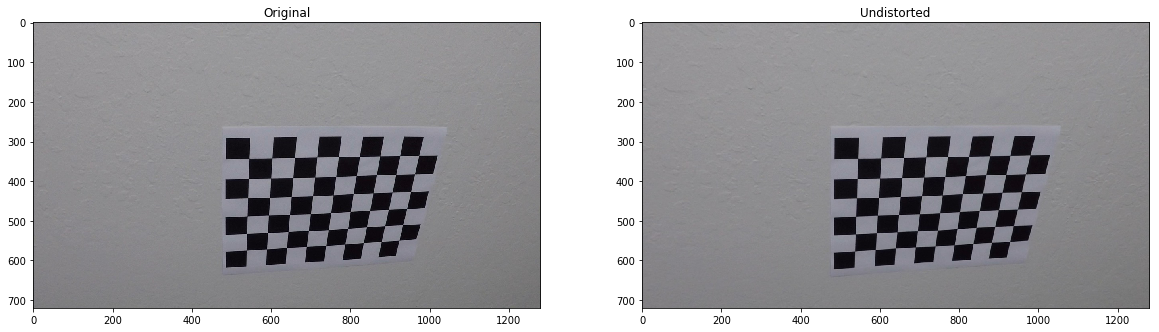

In [5]:
img = mpimg.imread(images[6])
    
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("Original")
ax1.imshow(img)

ax2.set_title("Undistorted")
ax2.imshow(undist_img)

## Transformation

here area some helper functions

In [6]:
test_images = glob.glob('./test_images/*.jpg')
challenge_images = glob.glob('./challenge_images/*.jpg')

In [7]:
# given two points and a new_x, we define an y equivalent
# good to change the size of line
def find_y_line(x_min, x_max, y_min, y_max, new_x):
    del_y = y_min - y_max
    del_x = x_max - x_min
    slope = del_y / del_x

    b = y_min - (x_max * slope)
    
    # y = mx + b
    y = (slope * new_x) + b
    return y

def draw_lines(img, lines, color=(255, 0, 0), thickness=1):
    for x1, y1, x2, y2 in lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def extract_points_mask(img):
    imshape = img.shape
    
    rows = imshape[0]
    cols = imshape[1]

    x_bl = int(.15 * cols)
    x_tl = int(.469 * cols)
    x_tr = int(.532 * cols)
    x_br = int(.875 * cols)

    y_top = int(0.62 * rows)
    
    return x_bl, x_tl, x_tr, x_br, y_top
    
def draw_mask(img):
    imshape = img.shape
    
    rows = imshape[0]
    cols = imshape[1]
    
    x_bl, x_tl, x_tr, x_br, y_top = extract_points_mask(img)

    # (x1, y1) (x2, y2)
    lines = []
    lines.append([x_bl, rows, x_tl, y_top]) #left_line
    lines.append([x_tl, y_top, x_tr, y_top]) #top_line
    lines.append([x_tr, y_top, x_br, rows]) #right_line

    draw_lines(img, lines)
        
def warp(img, src, dest):
    
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [8]:
# gradients

def abs_sobel_thresh(img, orient='x', thresh=(0, 255), use_S_channel=False, sobel_kernel=3):
    
    img_src = None
    
    if use_S_channel:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_src = hls[:,:,2]
    else:
        img_src = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = None
    if orient == 'x':
        sobel = cv2.Sobel(img_src, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_src, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise Exception('The param ' + orient + ' is unknow')
        
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1        
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), use_S_channel=False):
    
    img_src = None
    
    if use_S_channel:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_src = hls[:,:,2]
    else:
        img_src = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    sobelx = cv2.Sobel(img_src, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_src, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # calculate magnitude
    abs_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(abs_sobel*255/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), use_S_channel=False):
    
    img_src = None
    
    if use_S_channel:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_src = hls[:,:,2]
    else:
        img_src = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(img_src, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_src, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_output

def hls_threshold(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
   
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

### Undistorted image sample

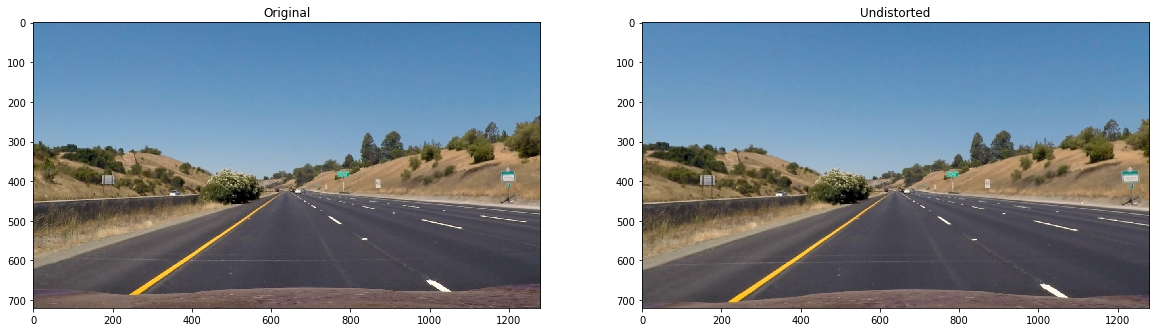

In [9]:
# undist image example
filename = test_images[0]
img_sobel = mpimg.imread(filename)

undist_img = undist(img_sobel)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("Original")
ax1.imshow(img_sobel)

ax2.set_title("Undistorted")
ax2.imshow(undist_img)

### Binary image

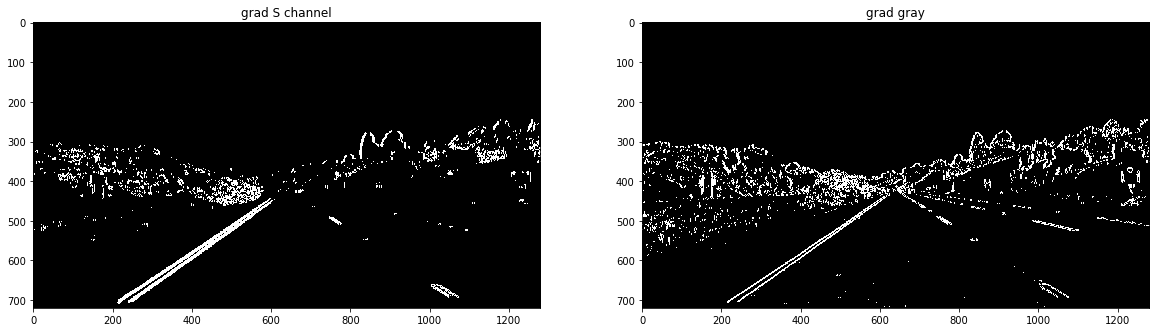

In [10]:
#filename = challenge_images[0]
filename = test_images[0]
img_sobel = mpimg.imread(filename)

img_sobel = undist(img_sobel)

grad_x = abs_sobel_thresh(img_sobel, thresh=(20, 130), sobel_kernel=5)
#grad_x = abs_sobel_thresh(img_sobel, thresh=(20, 130), sobel_kernel=7)
grad_x2 = abs_sobel_thresh(img_sobel, thresh=(20, 130), use_S_channel=True, sobel_kernel=9)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("grad S channel")
ax1.imshow(grad_x2, cmap='gray')

ax2.set_title("grad gray")
ax2.imshow(grad_x, cmap='gray')

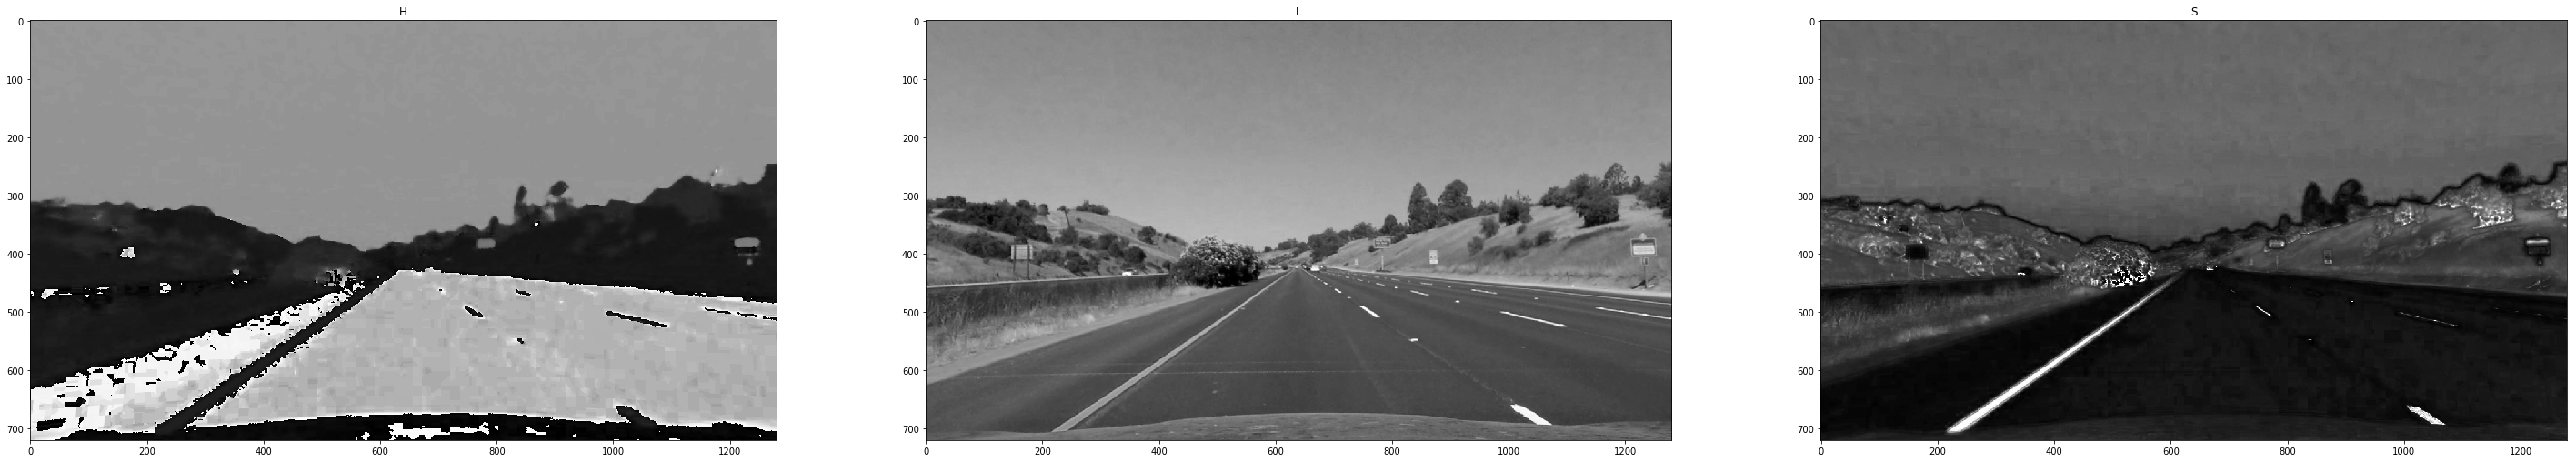

In [11]:
hls = cv2.cvtColor(img_sobel, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50, 10))

ax1.set_title("H")
ax1.imshow(H, cmap='gray')

ax2.set_title("L")
ax2.imshow(L, cmap='gray')

ax3.set_title("S")
ax3.imshow(S, cmap='gray')


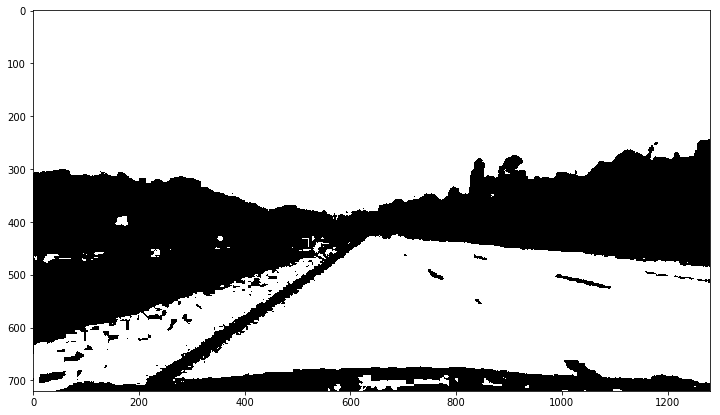

In [12]:
thresh = (100, 200)
h_binary = np.zeros_like(S)
h_binary[(H > thresh[0]) & (H <= thresh[1])] = 1

plt.figure(figsize = (40,7))
plt.imshow(h_binary, cmap='gray')

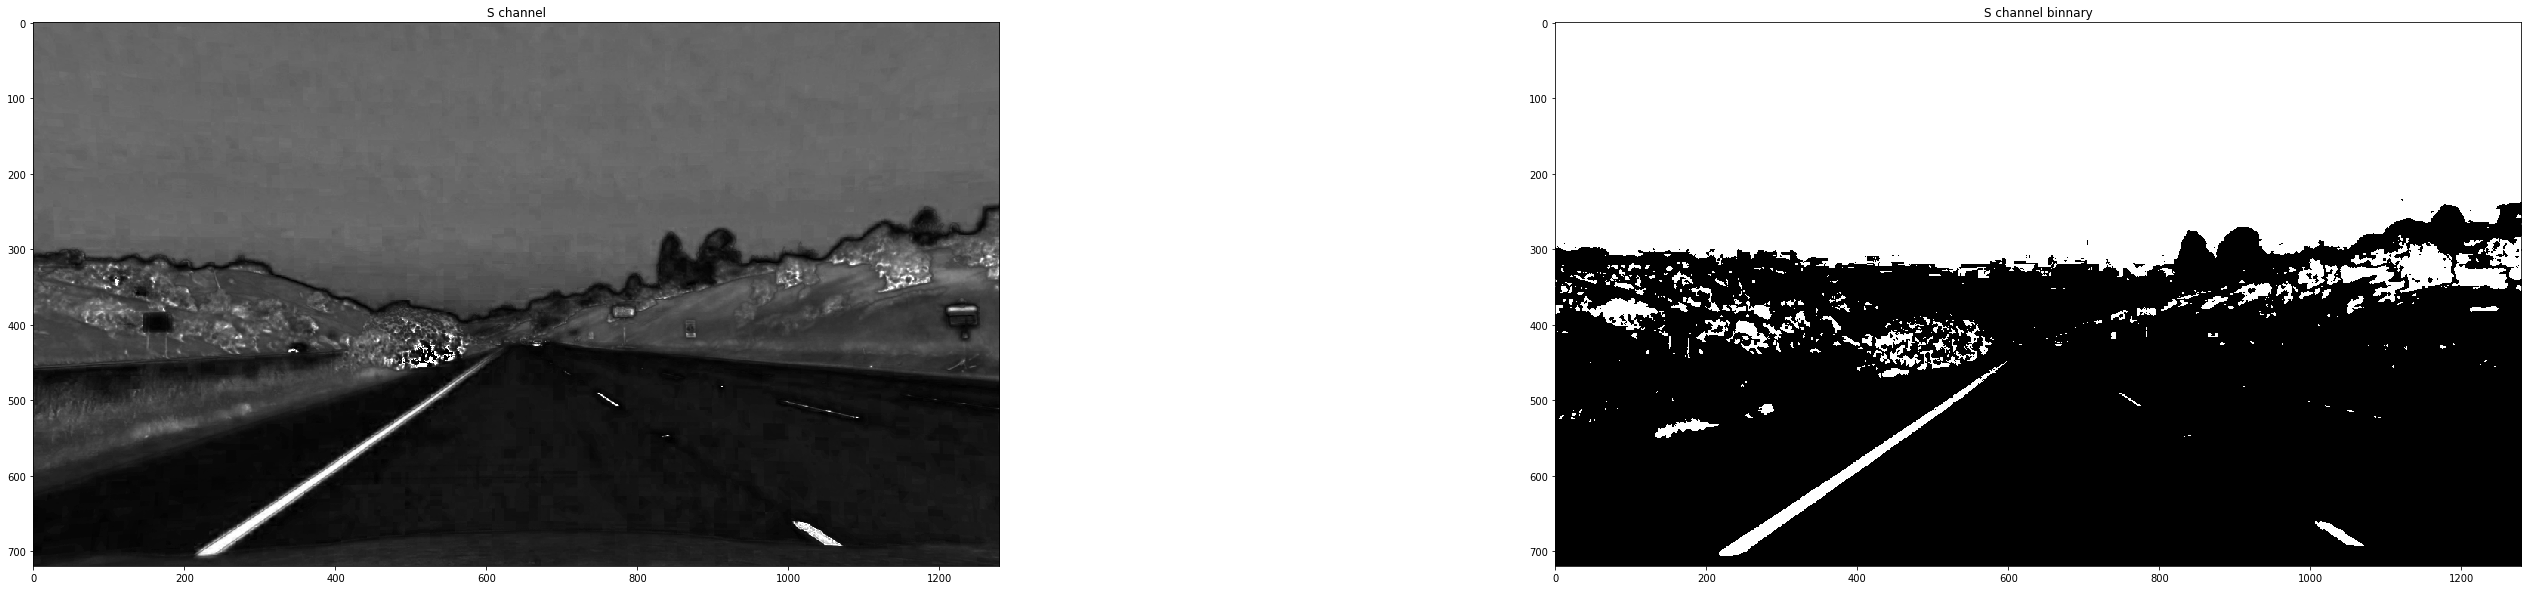

In [13]:
# hls threshold

# correct for the project
#s_tresh = hls_threshold(img_sobel, thresh=(130, 255))
# test on challenge
s_tresh = hls_threshold(img_sobel, thresh=(90, 255))

hls = cv2.cvtColor(img_sobel, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 10))

ax1.set_title("S channel")
ax1.imshow(s_channel, cmap='gray')

ax2.set_title("S channel binnary")
ax2.imshow(s_tresh, cmap='gray')

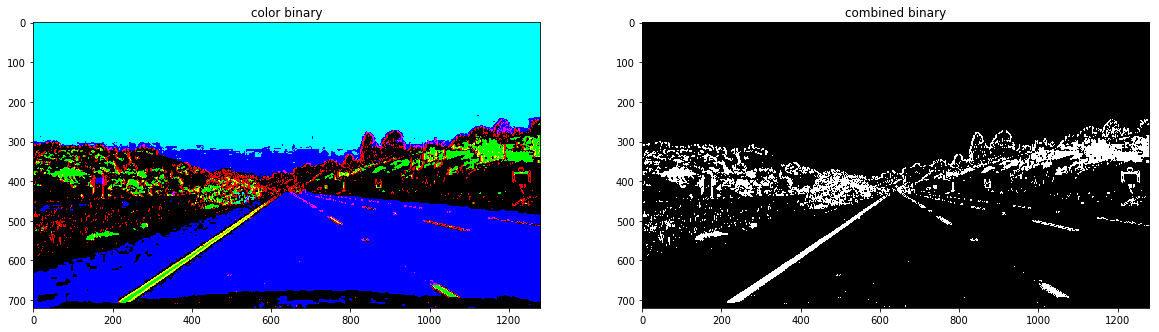

In [14]:
# r = grayscale gradient x
# g = s channel thresholded
# b = H channel removed area from  s_tresh
color_binary = np.dstack((grad_x, s_tresh, h_binary)) * 255


combined = np.zeros_like(s_tresh)
combined[((s_tresh == 1) & (s_tresh != h_binary)) | ((grad_x == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("color binary")
ax1.imshow(color_binary)

ax2.set_title("combined binary")
ax2.imshow(combined, cmap='gray')


### Perspective transform

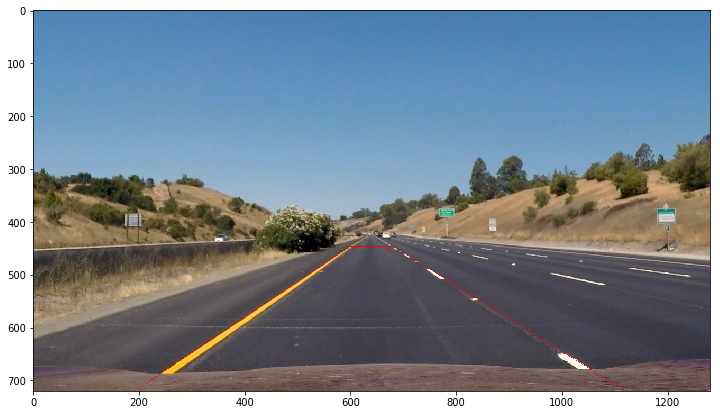

In [15]:
# draws a mask to see what points we should get
%matplotlib inline

img = mpimg.imread(filename)

draw_mask(img)
    
plt.figure(figsize = (40,7))
plt.imshow(img)

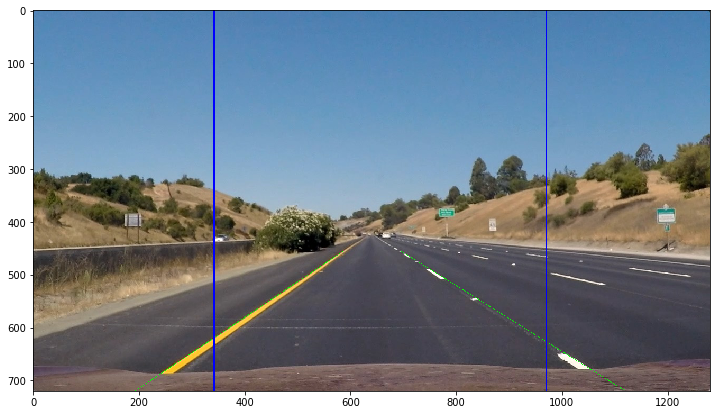

In [16]:
img_transf = mpimg.imread(filename)

imshape = img_transf.shape
    
rows = imshape[0]
cols = imshape[1]

x_bl, x_tl, x_tr, x_br, y_top = extract_points_mask(img)

# points that will be used in source points to transform
offset = -15
new_left_x = x_tl + offset
new_left_y = find_y_line(x_bl, x_tl, y_top, rows, new_left_x)
new_right_x = x_tr - offset
new_right_y = find_y_line(x_br, x_tr, y_top, rows, new_right_x)

src = np.float32([
    [x_bl, rows], 
    [new_left_x, new_left_y], 
    [new_right_x, new_right_y], 
    [x_br, rows] 
])

# increase the size of line (mask area)
increase_value = 150
x_left = x_bl + increase_value
x_right = x_br - increase_value

dest = np.float32([
    [x_left, rows], 
    [x_left, 0],
    [x_right, 0], 
    [x_right, rows]
])

# source points
draw_lines(img_transf, [
    [src[0][0], src[0][1], src[1][0], src[1][1]], 
    [src[2][0], src[2][1], src[3][0], src[3][1]]
], color=(0, 255, 0))

# destination points
draw_lines(img_transf, [
    [dest[0][0], dest[0][1], dest[1][0], dest[1][1]], 
    [dest[2][0], dest[2][1], dest[3][0], dest[3][1]]
    
], color=(0, 0, 255), thickness=2)

plt.figure(figsize = (40,7))
plt.imshow(img_transf)

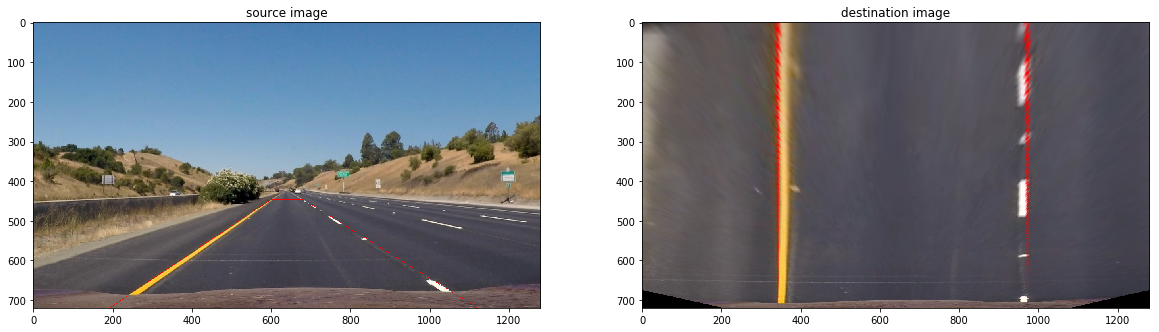

In [18]:
warped_img, _ = warp(img, src, dest)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("source image")
ax1.imshow(img)

ax2.set_title("destination image")
ax2.imshow(warped_img)

## Finding lane lines

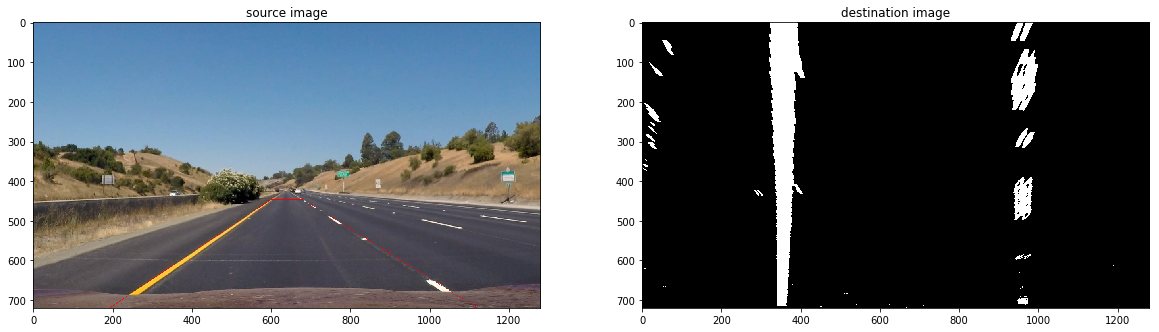

In [19]:
#draw_mask(combined)
    
warped_img, Minv = warp(combined, src, dest)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("source image")
ax1.imshow(img)

ax2.set_title("destination image")
ax2.imshow(warped_img, cmap='gray')

(1280,)


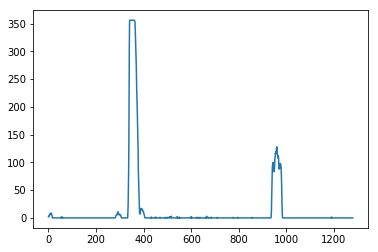

In [20]:
# finding lines
half_index = warped_img.shape[0]//2
histogram = np.sum(warped_img[half_index:,:], axis=0)
print(histogram.shape)

plt.plot(histogram)

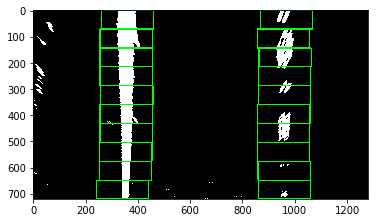

In [21]:
out_img = np.dstack((warped_img, warped_img, warped_img))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

cur_leftx_base = leftx_base
cur_rightx_base = rightx_base

height_img = warped_img.shape[0]
nwindows = 10
window_height = height_img//nwindows

# gets the nonzero indices in an array (1 dim) inner a tuple (0=dim1 and 1=dim2)
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

minpx = 150
margin = 100

left_lane_lines_inds = []
right_lane_lines_inds = []

for i in range(nwindows):

    # finds the left top point in the rectangle
    y_top = height_img - ((i + 1) * window_height)
    # finds the right bottom point in the rectangle
    y_bottom = height_img - (i * window_height)

    # draws the left window
    win_leftx_low = cur_leftx_base - margin
    win_leftx_high = cur_leftx_base + margin
    cv2.rectangle(out_img, (win_leftx_low, y_top), 
                           (win_leftx_high, y_bottom), 
                           (0, 255, 0), 3)

    # draws the right window
    win_rightx_low = cur_rightx_base - margin
    win_rightx_high = cur_rightx_base + margin
    cv2.rectangle(out_img, (win_rightx_low, y_top), 
                           (win_rightx_high, y_bottom), 
                           (0, 255, 0), 3)
    # recenter
    # where True we gets the indices
    good_left_ind = ((nonzerox >= win_leftx_low) & (nonzerox <= win_leftx_high) & 
                      (nonzeroy >= y_top) & (nonzeroy <= y_bottom)).nonzero()[0]
    
    good_right_ind = ((nonzerox >= win_rightx_low) & (nonzerox <= win_rightx_high) & 
                      (nonzeroy >= y_top) & (nonzeroy <= y_bottom)).nonzero()[0]
    
    # stores the indexes of the pixels that make up the line
    left_lane_lines_inds.append(good_left_ind)
    right_lane_lines_inds.append(good_right_ind)
    
    if len(good_left_ind) > minpx:
        cur_leftx_base = np.int(np.mean(nonzerox[good_left_ind]))
       
    if len(good_right_ind) > minpx:
        cur_rightx_base = np.int(np.mean(nonzerox[good_right_ind]))

left_lane_lines_inds = np.concatenate(left_lane_lines_inds)
right_lane_lines_inds = np.concatenate(right_lane_lines_inds)
        
plt.imshow(out_img)

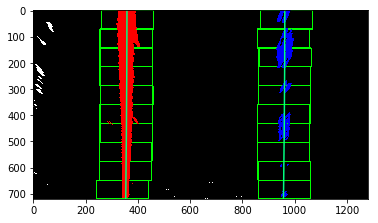

In [22]:
# gets the indexes of pixesl that make up the line
leftx = nonzerox[left_lane_lines_inds]
lefty = nonzeroy[left_lane_lines_inds]
rightx = nonzerox[right_lane_lines_inds]
righty = nonzeroy[right_lane_lines_inds]

# gets a vector of coefficients of deegre 2
# pass the y, x and the deegre
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# generates x and y values
start = 0
stop = warped_img.shape[0]-1
nsamples = warped_img.shape[0]
# returns an array of numbers for y
ploty = np.linspace(start, stop, nsamples)

# polynomial f(y) = a*yˆ2 + b*y + c
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# colors the pixels in window
out_img[lefty, leftx] = (255,0,0)
out_img[righty, rightx] = (0,0,255)

# plot the polynomial
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color=(0, 1, 0.5))
plt.plot(right_fitx, ploty, color=(0, 1, 0.5))


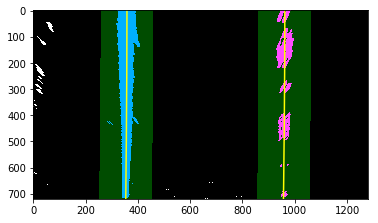

In [23]:
# searches in a margin around the previous line found

# simulate the next frame image
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# onde tiver pixel (nonzeroy) definimos uma fronteira de pesquisa
search_area_left_low = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin
search_area_leftx_high = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin
search_area_right_low = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin
search_area_right_high = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin

# now we don't need to build the windows
left_lane_lines_inds = ((nonzerox >= search_area_left_low) & (nonzerox <= search_area_leftx_high)).nonzero()[0]
right_lane_lines_inds = ((nonzerox >= search_area_right_low) & (nonzerox <= search_area_right_high)).nonzero()[0]

leftx = nonzerox[left_lane_lines_inds]
lefty = nonzeroy[left_lane_lines_inds]
rightx = nonzerox[right_lane_lines_inds]
righty = nonzeroy[right_lane_lines_inds]

# gets a vector of coefficients of deegre 2
# pass the y, x and the deegre
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# generates x and y values
start = 0
stop = warped_img.shape[0]-1
nsamples = warped_img.shape[0]
# returns an array of numbers for y
ploty = np.linspace(start, stop, nsamples)

# polynomial f(y) = a*yˆ2 + b*y + c
# midline of pixels
# we are fitting for f(y), rather than f(x), because the lane lines in the 
# warped image are near vertical and may have the same x value for more than one y value.
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# visualize the result

out_img = np.dstack((warped_img, warped_img, warped_img))*255
window_img = np.zeros_like(out_img)

# apply color in the selected pixels
out_img[lefty, leftx] = [0, 100, 255]
out_img[righty, rightx] = [255, 0, 255]

# generate a polygon to illustrate the search window area
# and recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# draws the polygon on out_img
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [24]:
# measuring the curvature

# maximum y-value, corresponding to the bottom of the image
y_eval = warped_img.shape[0]

left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print(left_curverad, right_curverad)

70102.427743 56556.5431643


In [25]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/warped_img.shape[0] # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# polynomial coefficients with meters
left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

y_eval_m = y_eval*ym_per_pix

# calculates the new radii of curvature
left_curverad = ((1 + (2*left_fit_m[0]*y_eval_m + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
right_curverad = ((1 + (2*right_fit_m[0]*y_eval_m + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])

# now we have the measurements in meters
print(left_curverad, 'm', right_curverad, 'm')

23020.8726051 m 18571.0716514 m


## Test on videos

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import copy

In [27]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        # polynomial coefficients of the last n fit
        self.recent_fit = []
        
        # number of rollbacks in a row
        self.n_rollbacks = 0
    
    # x values of polynomial
    def add_xfitted(self, xfitted):
        self.recent_xfitted.append(xfitted)
        # matem n ultimos elementos
        n = 5
        self.recent_xfitted = self.recent_xfitted[-n:]
        self.bestx = np.average(self.recent_xfitted, axis=0)
        
    def set_current_fit(self, current_fit):
        self.current_fit = current_fit
        
        self.recent_fit.append(current_fit)
        
        # matem n ultimos elementos
        n = 5
        self.recent_fit = self.recent_fit[-n:]
        self.best_fit = np.average(self.recent_fit, axis=0)
        
    def get_indexes_of_line(self, img, nonzero, x_base):
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        minpx = 100
        margin = 100

        lines_inds = []
        
        if self.detected == False:
            self.detected = True
            
            cur_x_base = x_base
            
            height_img = img.shape[0]
            nwindows = 10
            window_height = height_img//nwindows

            for i in range(nwindows):

                # finds the left top point in the rectangle
                y_top = height_img - ((i + 1) * window_height)
                # finds the right bottom point in the rectangle
                y_bottom = height_img - (i * window_height)


                # defines the left window
                win_x_low = cur_x_base - margin
                win_x_high = cur_x_base + margin

                # where True we gets the indices
                good_ind = ((nonzerox >= win_x_low) & (nonzerox <= win_x_high) & 
                                  (nonzeroy >= y_top) & (nonzeroy <= y_bottom)).nonzero()[0]

                # stores the indexes of the pixels that make up the line
                lines_inds.append(good_ind)

                # recenter
                if len(good_ind) > minpx:
                    cur_x_base = np.int(np.mean(nonzerox[good_ind]))

            lines_inds = np.concatenate(lines_inds)
        else:
            # onde tiver pixel (nonzeroy) definimos uma fronteira de pesquisa
            search_area_x_low = self.best_fit[0]*nonzeroy**2 + \
                                   self.best_fit[1]*nonzeroy + \
                                   self.best_fit[2] - margin
            search_area_x_high = self.best_fit[0]*nonzeroy**2 + \
                                   self.best_fit[1]*nonzeroy + \
                                   self.best_fit[2] + margin

            # now we don't need to build the windows
            lines_inds = ((nonzerox >= search_area_x_low) & (nonzerox <= search_area_x_high)).nonzero()[0]
            
        # gets the indexes of pixel that make up the line
        self.allx = nonzerox[lines_inds]
        self.ally = nonzeroy[lines_inds]
        
    def sanity_check(self, other_curverad, bases_left_right=(0, 0)):
        good_measurement = True
        
        # checking that they have similar curvature
        min_curvature_diff = self.radius_of_curvature - (self.radius_of_curvature/2)
        max_curvature_diff = self.radius_of_curvature + (self.radius_of_curvature/2)
        
        if (other_curverad < min_curvature_diff) | (other_curverad > max_curvature_diff):
            good_measurement = False
            
        # checking that they are separated by approximately the right distance horizontally
        xm_per_pix = 3.7/700
        dist_hor = (bases_left_right[1] - bases_left_right[0]) * xm_per_pix
        if dist_hor > 4 or dist_hor < 3:
            print('irregular distance horizontally', dist_hor)
            good_measurement = False
            
        if good_measurement:
            # if we gets a good measurement we reset the number of roolbacks
            self.n_rollbacks = 0
            
        return good_measurement
    
    def rollback(self, previous_state):
        self.detected = previous_state.detected  
        self.recent_xfitted = previous_state.recent_xfitted
        self.bestx = previous_state.bestx
        self.best_fit = previous_state.best_fit
        self.current_fit = previous_state.current_fit
        self.radius_of_curvature = previous_state.radius_of_curvature
        self.line_base_pos = previous_state.line_base_pos
        self.diffs = previous_state.diffs
        self.allx = previous_state.allx
        self.ally = previous_state.ally
        self.recent_fit = previous_state.recent_fit
        
        self.n_rollbacks += 1
        
        if self.n_rollbacks > 15:
            # init from stratch
            print('init search from stratch')
            self.n_rollbacks = 0
            self.detected = False

In [28]:
def process_image(image, left_line, right_line):
    
    # allow rollback in case of bad detection
    left_previous_state = copy.deepcopy(left_line)
    right_previous_state = copy.deepcopy(right_line)
    
    image = undist(image)
    
    grad_x = abs_sobel_thresh(image, thresh=(20, 130), sobel_kernel=5)
    #grad_x = abs_sobel_thresh(img_sobel, thresh=(20, 130), sobel_kernel=9)

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]

    thresh = (100, 200)
    h_binary = np.zeros_like(H)
    h_binary[(H > thresh[0]) & (H <= thresh[1])] = 1


    #project
    #s_tresh = hls_threshold(image, thresh=(130, 255))
    s_tresh = hls_threshold(image, thresh=(90, 255))

    combined = np.zeros_like(s_tresh)
    combined[((s_tresh == 1) & (s_tresh != h_binary)) | ((grad_x == 1) ) ] = 1

    imshape = image.shape

    rows = imshape[0]
    cols = imshape[1]

    x_bl, x_tl, x_tr, x_br, y_top = extract_points_mask(image)

    # points that will be used in source points to transform
    #offset = 40
    offset = -15
    new_left_x = x_tl + offset
    new_left_y = find_y_line(x_bl, x_tl, y_top, rows, new_left_x)
    new_right_x = x_tr - offset
    new_right_y = find_y_line(x_br, x_tr, y_top, rows, new_right_x)

    src = np.float32([
        [x_bl, rows], 
        [new_left_x, new_left_y], 
        [new_right_x, new_right_y], 
        [x_br, rows] 
    ])

    # increase the size of line (mask area)
    increase_value = 150
    x_left = x_bl + increase_value
    x_right = x_br - increase_value

    dest = np.float32([
        [x_left, rows], 
        [x_left, 0],
        [x_right, 0], 
        [x_right, rows]
    ])

    warped_img, Minv = warp(combined, src, dest)
     
    half_index = warped_img.shape[0]//2
    histogram = np.sum(warped_img[half_index:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # gets the nonzero indices in an array (1 dim) inner a tuple (0=dim1 and 1=dim2)
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # get indexes of line
    left_line.get_indexes_of_line(warped_img, nonzero, leftx_base)
    right_line.get_indexes_of_line(warped_img, nonzero, rightx_base)
   
    # gets a vector of coefficients of deegre 2
    # pass the y, x and the deegre
    left_line.set_current_fit(np.polyfit(left_line.ally, left_line.allx, 2))
    right_line.set_current_fit(np.polyfit(right_line.ally, right_line.allx, 2))

    # generates x and y values
    start = 0
    stop = warped_img.shape[0]-1
    nsamples = warped_img.shape[0]
    # returns an array of numbers for y
    ploty = np.linspace(start, stop, nsamples)

    # polynomial f(y) = a*yˆ2 + b*y + c
    left_line.add_xfitted(left_line.best_fit[0]*ploty**2 + \
                          left_line.best_fit[1]*ploty + \
                          left_line.best_fit[2])
    right_line.add_xfitted(right_line.best_fit[0]*ploty**2 + \
                          right_line.best_fit[1]*ploty + \
                          right_line.best_fit[2])

    # measuring the curvature

    # maximum y-value, corresponding to the bottom of the image
    y_eval = warped_img.shape[0]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/warped_img.shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # polynomial coefficients with meters
    left_fit_m = np.polyfit(left_line.ally*ym_per_pix, left_line.allx*xm_per_pix, 2)
    right_fit_m = np.polyfit(right_line.ally*ym_per_pix, right_line.allx*xm_per_pix, 2)

    y_eval_m = y_eval*ym_per_pix

    # calculates the new radii of curvature
    left_line.radius_of_curvature = ((1 + (2*left_fit_m[0]*y_eval_m + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_line.radius_of_curvature = ((1 + (2*right_fit_m[0]*y_eval_m + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    
    polycolor = (0,255, 0)    
    
    if (left_line.sanity_check(
            right_line.radius_of_curvature, bases_left_right=(leftx_base,rightx_base)) == False):
        
        if left_previous_state.bestx is not None: # if we have previous state
            left_line.rollback(left_previous_state)
        if right_previous_state.bestx is not None: # if we have previous state
            right_line.rollback(right_previous_state)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), polycolor)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    # print texts

    # curvature
    mean_curvature = (left_line.radius_of_curvature + right_line.radius_of_curvature) // 2
    
    # distance from center
    center_point_lane = (leftx_base + rightx_base) / 2
    center_image = cols // 2
    distance = (center_image - center_point_lane) * xm_per_pix
    
    ## for debug (shows center of lane and the distance from center)
    ## draw_lines(result, [[center_image, 0, center_image, rows]], color=(255, 0, 0))
    ## draw_lines(result, [[int(center_point_lane), 0, int(center_point_lane), rows]], color=(0, 0, 255))
    
    text_curvature = "Radius of Curvature = {0:.0f}(m)".format(mean_curvature)
    text_distance = "Vehicle is {0:.2f}m {1} of center".format(
        abs(distance), "right" if distance > 0 else "left")
    
    cv2.putText(result, text_curvature, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(result, text_distance, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
        
    return result
    

In [29]:
output_dir = 'videos_output/1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
video_input = "project_video.mp4"
## video_input = "challenge_video.mp4"
## video_input = "harder_challenge_video.mp4"
#videocap = cv2.VideoCapture(video_input)
clip1 = VideoFileClip(video_input)##.subclip(0, 5)

# save img
'''
_,image = videocap.read()
count = 0
while count < 4:
  _,image = videocap.read()
  cv2.imwrite("challenge_images/challeng_%d.jpg" % count, image)     # save frame as JPEG file
  count += 1
'''

left_line = Line()
right_line = Line()
white_clip = clip1.fl_image(lambda img: process_image(img, left_line, right_line)) 

%time white_clip.write_videofile(output_dir, audio=False)

[MoviePy] >>>> Building video videos_output/1.mp4
[MoviePy] Writing video videos_output/1.mp4


  2%|▏         | 19/1261 [00:02<03:16,  6.33it/s]

irregular distance horizontally 2.90714285714
irregular distance horizontally 2.94414285714


  3%|▎         | 44/1261 [00:06<03:09,  6.43it/s]

irregular distance horizontally 2.97057142857


  5%|▌         | 69/1261 [00:10<03:12,  6.20it/s]

irregular distance horizontally 2.90714285714
init search from stratch
irregular distance horizontally 2.92828571429


  6%|▌         | 70/1261 [00:10<03:14,  6.12it/s]

irregular distance horizontally 2.98114285714


  7%|▋         | 94/1261 [00:14<03:10,  6.13it/s]

irregular distance horizontally 2.96


  8%|▊         | 97/1261 [00:15<03:23,  5.72it/s]

init search from stratch


 15%|█▌        | 194/1261 [00:30<02:53,  6.15it/s]

irregular distance horizontally 2.93885714286
irregular distance horizontally 2.93885714286


 16%|█▌        | 196/1261 [00:31<02:55,  6.06it/s]

irregular distance horizontally 2.97585714286


 24%|██▍       | 306/1261 [00:49<02:31,  6.30it/s]

init search from stratch


 26%|██▌       | 327/1261 [00:52<02:29,  6.26it/s]

init search from stratch


 28%|██▊       | 352/1261 [00:56<02:24,  6.29it/s]

init search from stratch


 30%|██▉       | 373/1261 [00:59<02:24,  6.17it/s]

init search from stratch


 32%|███▏      | 399/1261 [01:04<02:53,  4.98it/s]

init search from stratch


 33%|███▎      | 418/1261 [01:08<03:02,  4.62it/s]

init search from stratch


 35%|███▌      | 447/1261 [01:13<02:26,  5.54it/s]

init search from stratch


 37%|███▋      | 471/1261 [01:17<02:11,  6.00it/s]

init search from stratch


 39%|███▊      | 488/1261 [01:20<02:06,  6.09it/s]

init search from stratch


 40%|████      | 507/1261 [01:24<02:28,  5.08it/s]

init search from stratch


 42%|████▏     | 527/1261 [01:28<02:14,  5.46it/s]

init search from stratch


 43%|████▎     | 546/1261 [01:31<02:02,  5.82it/s]

init search from stratch


 45%|████▍     | 567/1261 [01:35<02:05,  5.54it/s]

init search from stratch


 47%|████▋     | 592/1261 [01:39<01:47,  6.20it/s]

init search from stratch


 50%|████▉     | 625/1261 [01:44<01:50,  5.73it/s]

init search from stratch


 51%|█████     | 638/1261 [01:47<01:41,  6.15it/s]

irregular distance horizontally 2.93357142857


 60%|█████▉    | 756/1261 [02:06<01:25,  5.92it/s]

irregular distance horizontally 2.98114285714
init search from stratch
irregular distance horizontally 2.997


 72%|███████▏  | 905/1261 [02:33<00:57,  6.16it/s]

init search from stratch


 78%|███████▊  | 986/1261 [02:47<00:47,  5.84it/s]

init search from stratch


 80%|████████  | 1014/1261 [02:52<00:46,  5.30it/s]

init search from stratch


 84%|████████▍ | 1063/1261 [03:02<00:36,  5.44it/s]

irregular distance horizontally 2.95471428571


 85%|████████▍ | 1071/1261 [03:03<00:40,  4.68it/s]

init search from stratch


 89%|████████▉ | 1120/1261 [03:13<00:21,  6.52it/s]

init search from stratch


 93%|█████████▎| 1173/1261 [03:21<00:12,  6.82it/s]

init search from stratch


 98%|█████████▊| 1232/1261 [03:30<00:03,  7.37it/s]

init search from stratch


100%|█████████▉| 1256/1261 [03:33<00:00,  6.93it/s]

init search from stratch


100%|█████████▉| 1260/1261 [03:34<00:00,  7.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/1.mp4 

CPU times: user 3min 40s, sys: 37.6 s, total: 4min 17s
Wall time: 3min 35s
